In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data=pd.read_csv("datasetSeries.csv")[['Close']]

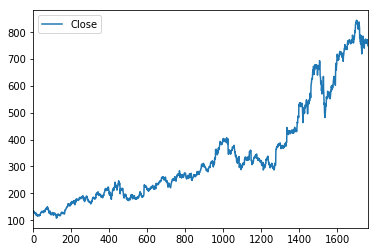

In [3]:
data.plot()

In [4]:
train_data=data.iloc[0:1600,:]
test_data=data.iloc[1600:,:]

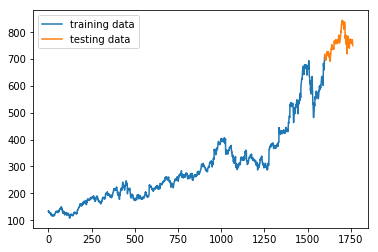

In [5]:
plt.plot(train_data.index,train_data.Close,label='training data')
plt.plot(test_data.index,test_data.Close,label='testing data')
plt.legend()

In [6]:
from sklearn.preprocessing import MinMaxScaler
s=MinMaxScaler()
X_train=s.fit_transform(train_data).flatten()
X_test=s.transform(test_data).flatten()

In [7]:
time_stamp=10
batch_size=32

In [8]:
l=[]
for seq in range(X_train.shape[0]-(time_stamp+1)): #10 = time step
    l.append(X_train[seq:(time_stamp+1)+seq])

In [9]:
ALLSeries=np.array(l) # all of size 10 + 1 elements
X_series,y_val=ALLSeries[:,0:-1].reshape(-1,time_stamp,1),ALLSeries[:,-1]

In [10]:
d=tf.data.Dataset.from_tensor_slices((X_series,y_val))
d=d.batch(batch_size)
d=d.apply(tf.data.experimental.shuffle_and_repeat(1024))
d=d.apply(tf.data.experimental.prefetch_to_device("/gpu:0",buffer_size=tf.data.experimental.AUTOTUNE))
iterator=tf.data.make_one_shot_iterator(d)
next_element = iterator.get_next()

In [11]:
with tf.Session() as sess:
    bx,by=sess.run(next_element)

In [12]:
#model

In [13]:
x=tf.placeholder(dtype=tf.float32,shape=[None,time_stamp,1])
y=tf.placeholder(dtype=tf.float32)

def RNN_GRU():
    model=tf.reshape(x,shape=[-1,1])
    model=tf.keras.layers.Dense(50,activation='relu')(model)
    model=tf.reshape(model,shape=[-1,time_stamp,50])
        #//rnn cell////

    cell=tf.nn.rnn_cell.GRUCell(50,activation='relu')
    output,final_state=tf.nn.dynamic_rnn(cell,model,dtype=tf.float32)

    model=tf.keras.layers.Dense(1,activation=None)(final_state)
    return model

model=RNN_GRU()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
This class is equivalent as tf.keras.layers.GRUCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API


In [14]:
cost=tf.losses.mean_squared_error(labels=y,predictions=model)

optimizer=tf.train.AdamOptimizer(learning_rate=0.001)

gvs=optimizer.compute_gradients(cost)
capped_gvs = [(tf.clip_by_value(grad, -1., 1.), var) for grad, var in gvs]
train_op = optimizer.apply_gradients(capped_gvs)
#train_op=optimizer.minimize(cost)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.


In [15]:
saver=tf.train.Saver()

In [16]:
##Training

In [17]:
steps=10000
loss=[]

In [18]:
init=tf.global_variables_initializer()

In [19]:
with tf.Session() as sess:
    #saver.restore(sess,"./SessSave/mysess.ckpt")
    sess.run(init)
    for step in range(steps):
        bx,by=sess.run(next_element)
        _,e=sess.run([train_op,cost],feed_dict={x:bx,y:by})
        loss.append(e)
        if step%1000==0:
            print("ON STEP {}".format(step+1))
    saver.save(sess,"./SessSave/mysess.ckpt")

ON STEP 1
ON STEP 1001
ON STEP 2001
ON STEP 3001
ON STEP 4001
ON STEP 5001
ON STEP 6001
ON STEP 7001
ON STEP 8001
ON STEP 9001


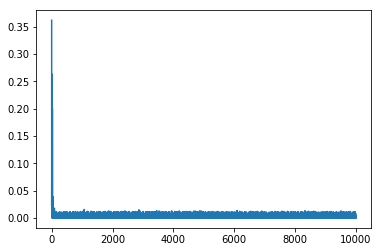

In [20]:
plt.plot(loss)

In [21]:
l=[]
for seq in range(X_test.shape[0]-(time_stamp+1)): #10 = time step
    l.append(X_test[seq:(time_stamp+1)+seq])
    
ALLSeries=np.array(l) # all of size 10 + 1 elements
X_test_series,y_test_val=ALLSeries[:,0:-1].reshape(-1,time_stamp,1),ALLSeries[:,-1]

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./SessSave/mysess.ckpt


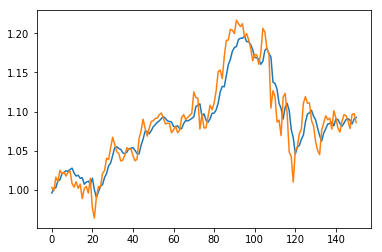

In [22]:
with tf.Session() as sess:
    saver.restore(sess,"./SessSave/mysess.ckpt")
    test_pred=sess.run(model,feed_dict={x:X_test_series})

plt.plot(test_pred)
plt.plot(y_test_val)

INFO:tensorflow:Restoring parameters from ./SessSave/mysess.ckpt


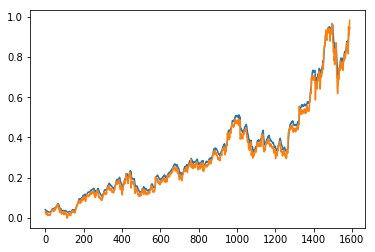

In [23]:
with tf.Session() as sess:
    saver.restore(sess,"./SessSave/mysess.ckpt")
    pred=sess.run(model,feed_dict={x:X_series})

plt.plot(pred)
plt.plot(y_val)

In [24]:
#NICE